# Quaternion Model

This model begins with the following Free Energy functional, with terms taken from Pusztai2005 and Dorr2010:

$$ F = \int_V (\frac{\epsilon_\phi^2T}{2}|\nabla \phi|^2 + f(\phi,c) + f_{ori}) dV \qquad (1)$$ 

In this equation, the bulk free energy, and the orientational mismatch energy are represented by the following equations:

$$ f(\phi, c) = Wg(\phi) + p(\phi)f_S + (1-p(\phi)f_L \qquad (2)$$

$$ 

In [2]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed

In [8]:
def __p(phi):
    return phi*phi*phi*(10-15*phi+6*phi*phi)

def __g(phi):
    return (phi*phi*(1-phi)*(1-phi))

def __gprime(phi):
    return (4*phi*phi*phi - 6*phi*phi +2*phi)

_p = np.vectorize(__p)
_g = np.vectorize(__g) 
_gprime = np.vectorize(__gprime)

def grad(phi, dx, i):
    phim = np.roll(phi, 1, 0)
    phip = np.roll(phi, -1, 0)
    return (phip-phim)/(2*dx)

def grad_l(phi, dx, i):
    phim = np.roll(phi, 1, 0)
    return (phi-phim)/(dx)

def grad_r(phi, dx, i):
    phip = np.roll(phi, -1, 0)
    return (phip-phi)/(dx)

def grad2(phi, dx):
    phim = np.roll(phi, 1, 0)
    phip = np.roll(phi, -1, 0)
    return (phip+phim-2*phi)/(dx*dx)

def renormalize(q1, q2, q3, q4):
    q = np.sqrt(q1*q1+q2*q2+q3*q3+q4*q4)
    return q1/q, q2/q, q3/q, q4/q

In [9]:
#material parameters
u = 100. #1 = cm, 100 = m
T_mA = 1728. #melting point of nickel
T_mB = 1358. #melting point of copper
L_A = 2350.*u*u*u #latent heat of nickel, J/m^3
L_B = 1728.*u*u*u #latent heat of copper, J/m^3
s_A = 0.000037*u*u #surface energy of nickel, J/m^2
s_B = 0.000029*u*u #surface energy of copper, J/m^2
D_L = 1e-5/(u*u) #diffusion in liquid, m^2/s
D_S = 1e-9/(u*u) #diffusion in solid, m^2/s
B_A = 0.33/u #linear kinetic coefficient of nickel, m/K/s
B_B = 0.39/u #linear kinetic coefficient of copper, m/K/s
v_m = 7.42/(u*u*u) #molar volume, m^3/mol
R = 8.314 #gas constant, J/mol*K
y_e = 0.06 #anisotropy

In [51]:
#this code block initializes the simulation

np.set_printoptions(threshold=np.inf)
T = 1574.
res = 81
dx = 4.6e-6/u #spacial division, cm
dx = 1.31e-6/u/4
dt = dx*dx/5./D_L
dt = 1.31e-9*0.1
d = dx/0.94*4 #interfacial thickness
ebar = np.sqrt(6*np.sqrt(2)*s_A*d/T_mA) #baseline energy
eqbar = ebar*0.1
W_A = 3*s_A/(np.sqrt(2)*T_mA*d)
W_B = 3*s_B/(np.sqrt(2)*T_mB*d)
M_A = T_mA*T_mA*B_A/(6*np.sqrt(2)*L_A*d)
M_B = T_mB*T_mB*B_B/(6*np.sqrt(2)*L_B*d)
print(M_A)
print(ebar)

c = np.zeros(res)
phi = np.zeros(res)
q1 = np.zeros(res)
q2 = np.zeros(res)
q3 = np.zeros(res)
q4 = np.zeros(res)
c += 0.40831
#c += 0.001*np.random.rand(res, res)
phi[0] = 1
phi[res-1] = 1
for i in range(res):
    q1[i] = (0.3*i)/(res-1)+0.5
    q2[i] = (0.3*(res-i-1))/(res-1)+0.5
    q3[i] = (0.2*i)/(res-1)+0.1
    q4[i] = (0.5*(res-i-1))/(res-1)+0.2
    
print(q1)
print(q2)

reference = np.zeros(res)
for i in range(res):
    reference[i] = i
    
step = 0

35.4587860825
5.03192127727e-06
[ 0.5      0.50375  0.5075   0.51125  0.515    0.51875  0.5225   0.52625
  0.53     0.53375  0.5375   0.54125  0.545    0.54875  0.5525   0.55625
  0.56     0.56375  0.5675   0.57125  0.575    0.57875  0.5825   0.58625
  0.59     0.59375  0.5975   0.60125  0.605    0.60875  0.6125   0.61625
  0.62     0.62375  0.6275   0.63125  0.635    0.63875  0.6425   0.64625
  0.65     0.65375  0.6575   0.66125  0.665    0.66875  0.6725   0.67625
  0.68     0.68375  0.6875   0.69125  0.695    0.69875  0.7025   0.70625
  0.71     0.71375  0.7175   0.72125  0.725    0.72875  0.7325   0.73625
  0.74     0.74375  0.7475   0.75125  0.755    0.75875  0.7625   0.76625
  0.77     0.77375  0.7775   0.78125  0.785    0.78875  0.7925   0.79625
  0.8    ]
[ 0.8      0.79625  0.7925   0.78875  0.785    0.78125  0.7775   0.77375
  0.77     0.76625  0.7625   0.75875  0.755    0.75125  0.7475   0.74375
  0.74     0.73625  0.7325   0.72875  0.725    0.72125  0.7175   0.71375
  0.71  

In [138]:
# This block runs the simulation for some number of time steps

#add these values after evolving the simulation to almost stability - to test if the interface in phi is truly stable
#phi = np.zeros(res)
#phi += 1

time_steps = 10000

# original number is the one used in Pusztai2005 and Granasy2014
# multiplication factor is used to ensure q is stable
dt = 1.31e-9 
dt *= 0.1

for i in range(time_steps):
    step += 1
    #print(i)
    g = _g(phi)
    p = _p(phi)
    gprime = _gprime(phi)
    H_A = W_A*gprime - 30*L_A*(1/T-1/T_mA)*g
    H_B = W_B*gprime - 30*L_B*(1/T-1/T_mB)*g
    phixx = grad2(phi, dx)
    lphi = phixx
    phix = grad(phi, dx, i)
    gq1l = grad_l(q1, dx, i)
    gq2l = grad_l(q2, dx, i)
    gq3l = grad_l(q3, dx, i)
    gq4l = grad_l(q4, dx, i)
    gqsl = gq1l*gq1l+gq2l*gq2l+gq3l*gq3l+gq4l*gq4l
    
    gq1r = np.roll(gq1l, -1, 0)
    gq2r = np.roll(gq2l, -1, 0)
    gq3r = np.roll(gq3l, -1, 0)
    gq4r = np.roll(gq4l, -1, 0)
    
    gq1 = (gq1l+gq1r)/2
    gq2 = (gq2l+gq2r)/2
    gq3 = (gq3l+gq3r)/2
    gq4 = (gq4l+gq4r)/2
    
    #print(gq1)
    smallest = 1e7*u*u
    #print(gqs)
    
    for i in range(res):
        if(gqsl[i] < smallest):
            gqsl[i] = smallest
              
    gqsr = np.roll(gqsl, -1, 0)
    rgqsl = np.sqrt(gqsl)
    rgqsr = np.roll(rgqsl, -1, 0)
    
    gqs = (gqsl+gqsr)/2
    rgqs = np.sqrt(gqs)
    
    lq1 = grad2(q1, dx)
    lq2 = grad2(q2, dx)
    lq3 = grad2(q3, dx)
    lq4 = grad2(q4, dx)
    gqs2 = gq1*lq1+gq2*lq2+gq3*lq3+gq4*lq4
    
    H = 5e-11*u*u # surface energy term for quaternions
    
    #change in c
    D_C = D_L+p*(D_S-D_L)
    temp = D_C*v_m*c*(1-c)*(H_B-H_A)/R
    deltac = D_C*(grad2(c, dx))+(grad(D_C, dx, i)*grad(c, dx, i))+temp*(lphi)+(grad(temp, dx, i)*phix)
    #print(deltac)
    #print(temp)
    
    phi2 = phi*phi
    
    #change in phi
    M_phi = 1.*((1-c)*M_A + c*M_B)
    deltaphi = M_phi*(ebar*ebar*lphi-(1-c)*H_A-c*H_B-4*H*T*phi*rgqs)
    #randArray = 2*np.random.rand(res)-1
    #alpha = 0.3
    #deltaphi += M_phi*alpha*randArray*(16*g)*((1-c)*H_A+c*H_B)
    
    #changes in q
    M_q = 10.*M_phi*(1-p)
    #M_q = 0 #temp
    
    
    gaq1 = ((0.5*(phi2+np.roll(phi2, -1, 0))*gq1r/rgqsr)-(0.5*(phi2+np.roll(phi2, 1, 0))*gq1l/rgqsl))/(dx)
    gaq2 = ((0.5*(phi2+np.roll(phi2, -1, 0))*gq2r/rgqsr)-(0.5*(phi2+np.roll(phi2, 1, 0))*gq2l/rgqsl))/(dx)
    gaq3 = ((0.5*(phi2+np.roll(phi2, -1, 0))*gq3r/rgqsr)-(0.5*(phi2+np.roll(phi2, 1, 0))*gq3l/rgqsl))/(dx)
    gaq4 = ((0.5*(phi2+np.roll(phi2, -1, 0))*gq4r/rgqsr)-(0.5*(phi2+np.roll(phi2, 1, 0))*gq4l/rgqsl))/(dx)
    t1 = eqbar*eqbar*lq1+H*T*(gaq1)
    t2 = eqbar*eqbar*lq2+H*T*(gaq2)
    t3 = eqbar*eqbar*lq3+H*T*(gaq3)
    t4 = eqbar*eqbar*lq4+H*T*(gaq4)
    second = (q1*t1+q2*t2+q3*t3+q4*t4)
    deltaq1 = M_q*(t1-q1*second)
    deltaq2 = M_q*(t2-q2*second)
    deltaq3 = M_q*(t3-q3*second)
    deltaq4 = M_q*(t4-q4*second)
    #print(deltaq1)
    
    #apply changes
    deltaphi[0] = 0
    deltac[0] = 0
    deltaq1[0] = 0
    deltaq2[0] = 0
    deltaq3[0] = 0
    deltaq4[0] = 0
    deltaphi[res-1] = 0
    deltac[res-1] = 0
    deltaq1[res-1] = 0
    deltaq2[res-1] = 0
    deltaq3[res-1] = 0
    deltaq4[res-1] = 0
    #print(c)
    #print(phi)
    #print(q1)
    #print(q2)
    #print(q3)
    #print(q4)
    #print(gqs)
    #print("gp2r:", gp2r)
    #print("Second: ", second)
    #print("t4:", t4)
    
    ctemp = c.copy()
    c += deltac*dt
    phi += deltaphi*dt
    q1 += deltaq1*dt
    q2 += deltaq2*dt
    q3 += deltaq3*dt
    q4 += deltaq4*dt
    if(i%10 == 0):
        q1, q2, q3, q4 = renormalize(q1, q2, q3, q4)

#print(c)
#print(phi)
#print(q1)
#print(q2)
#print(q3)
#print(q4)    
print("Done")

Done


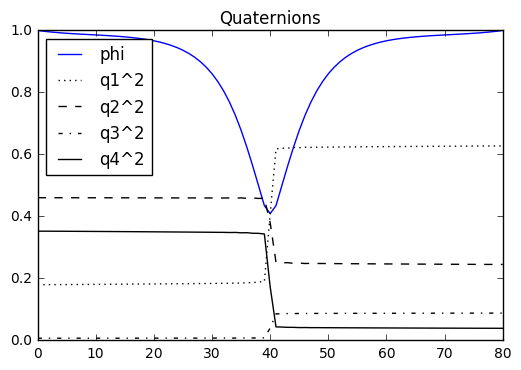

In [139]:
# This code block prints the current graph of the interface

plt.rcParams['figure.figsize'] = 6, 4
plt.title('Quaternions')
plt.plot(reference,phi, 'b')
plt.plot(reference,q1*q1,'k:')
plt.plot(reference,q2*q2,'k--')
plt.plot(reference,q3*q3,'k-.')
plt.plot(reference,q4*q4,'k')
plt.legend(['phi', 'q1^2', 'q2^2', 'q3^2', 'q4^2'], loc=2)
plt.savefig('graph'+str(step)+'.png')

In [140]:
#This code block prints out the d(phi)/dt array, to see if the interface is stable

print(deltaphi)
print(rgqs)

[     0.           -209.71021318   -422.00254983   -639.65696734
   -865.60239545  -1102.8328036   -1354.3807904   -1623.31824768
  -1912.75893604  -2225.85934138  -2565.81923877  -2935.88229043
  -3339.3356027   -3779.50628444  -4259.75318652  -4783.45497211
  -5354.00716903  -5974.86932399  -6649.72778028  -7382.76620172
  -8178.82571494  -9043.16680992  -9980.94449097 -10997.0456453
 -12096.83150475 -13287.44133429 -14578.62627688 -15982.16762938
 -17508.22330706 -19156.23256442 -20910.44006765 -22769.41323377
 -24778.37219158 -26970.05378989 -29214.51746444 -31240.56977445
 -32666.20886306 -33041.14431734 -32022.99698657 -29542.5206351
 -28359.45895809 -29546.04020454 -32036.05808399 -33063.23106534
 -32696.133709   -31276.72203381 -29255.34905085 -27014.36165483
 -24825.48778247 -22819.28932364 -20963.20896005 -19211.82840791
 -17566.22424997 -16041.85693063 -14638.99538649 -13347.16631212
 -12154.33770834 -11050.69519482 -10029.32990665  -9085.43239138
  -8214.86455095  -7413.144